Q3 - We already have some council provided community technology in place. Which...
Free Wi Fi city libraries                                      198
Digital signs showing parking availability council carparks    178
Digital signs showing bus arrival times bus stops              149
Payment kiosks libraries                                        70
Traffic counters                                                68
Information kiosks outdoor spaces                               50
Free Wi Fi Mount                                                47
Smart street lights dim remotely save energy                    39
Smart bins tell need check                                      34
Smart seats City Centre charging stations free Wi Fi            26
                                                                16
Name: count, dtype: int64


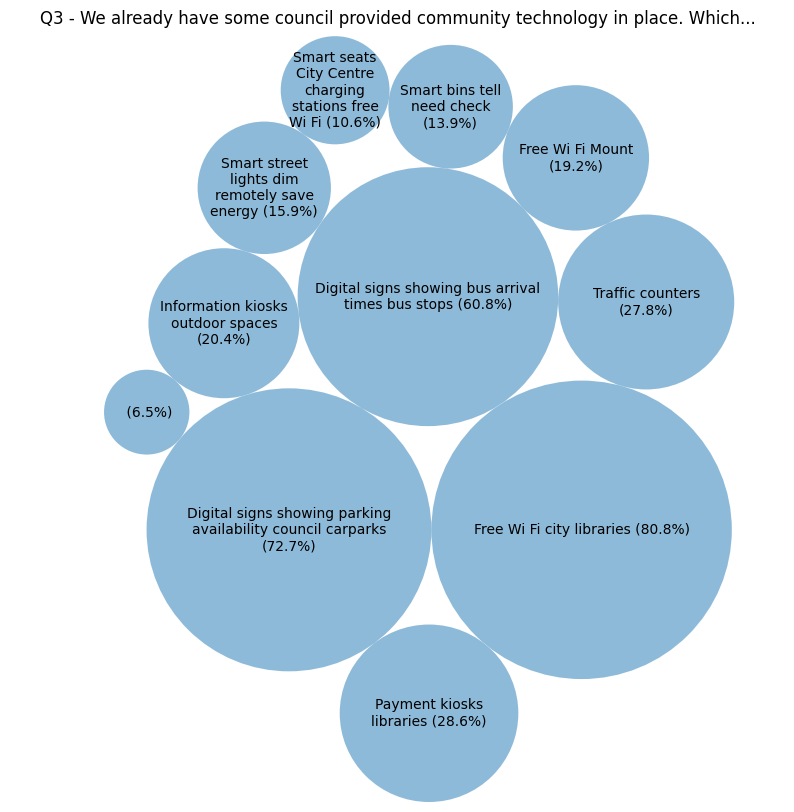

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import circlify
import textwrap
import spacy
from bs4 import BeautifulSoup

# Load spaCy's English model
nlp = spacy.load('en_core_web_sm')

# Read the CSV file
df = pd.read_csv('data/dashboard-export-02-51-am-2024-11-30.csv')  # Replace with the actual path to survey CSV file export
# print(df.columns)

num_cols = df.shape[0]

def visualise_column(column_name):
    # Extract the relevant column
    column = df[column_name].str.replace('Other, please specify.,', '', regex=False)

    # print(column)

    # Split the column into individual entries (if it's a comma-separated string)
    column_split = column.str.split(r'\s,|(?<=[a-zA-Z.]),(?=[a-zA-Z])').explode().str.strip()

    # Apply the simplification function to each entry in the column
    simplified_column = column_split.apply(simplify_text)

    # Count the occurrences of each unique entry
    column_counts = simplified_column.value_counts()

    print(column_counts)

    # Compute circle positions
    circles = circlify.circlify(
        column_counts.tolist(),
        show_enclosure=False,
        target_enclosure=circlify.Circle(x=0, y=0, r=1)
    )

    # Reverse the order of the circles to match the order of data
    circles = circles[::-1]

    # Create just a figure and only one subplot
    fig, ax = plt.subplots(figsize=(10, 10))

    # Title
    ax.set_title(column_name)

    # Remove axes
    ax.axis('off')

    # Find axis boundaries
    lim = max(
        max(
            abs(circle.x) + circle.r,
            abs(circle.y) + circle.r,
        )
        for circle in circles
    )
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)

    # List of labels (should correspond to unique values, not the original `df` column)
    labels = column_counts.index

    # Print circles with labels
    for circle, label, count in zip(circles, labels, column_counts):

        percentage = count / num_cols * 100

        x, y, r = circle
        ax.add_patch(plt.Circle((x, y), r, alpha=0.5, linewidth=2))

        # Dynamically set the wrap width based on the circle's radius (2 * r)
        wrap_width = int(2 * r * 50)  # Adjust the factor (here 10) to match text length better
        if wrap_width == 0:
            wrap_width = 10
        # Wrap the label text based on the circle's width
        wrapped_label = textwrap.fill(f"{label}\n({percentage:.1f}%)", width=wrap_width)

        # Annotate the circle with the wrapped label
        plt.annotate(
            wrapped_label,
            (x, y),
            va='center',
            ha='center',
            fontsize=10,  # Adjust font size as needed
            color='black'
        )

    # Show the plot
    plt.show()

# Function to process and simplify each technology entry
def simplify_text(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()

    # Process the text using spaCy
    doc = nlp(text)

    # Keep original words that are not stop words, not punctuation, and have more than 1 character
    simplified_tokens = [token.text for token in doc if not token.is_stop and not token.is_punct and len(token.text) > 1]

    # Return the simplified sentence (joined back together)
    return " ".join(simplified_tokens)

print(df.columns)
# visualise_column('Q4 - What technology would you like to see more of in our community? *\n\nPlease t...')
# visualise_column("Q3 - We already have some council provided community technology in place. Which...")
